In [1]:
import pickle
import pandas as pd
import numpy as np
import os

from tf_pose import common
from tf_pose.common import CocoPart

# lookback = steps back from the reference point for the training sample
# steps  = steps to sample in each lookback sample
# forward = step formward for the target frame
# lag = reference point lag

def pickle_to_sequence(file, lookback, steps, forward, lag):
    
    # load pickle
    humans = pd.read_pickle(file)
    
    # numpy matrix init      
    seq_data = np.zeros((len(humans), 18, 2))
    
    # loop over timesteps
    for t, human in enumerate(humans):
    
        # human 1 only if it exists, otherwise the previous time step
        if human[1] != []:
            # body part if it exists, otherwise the previous coords
            for i in range(common.CocoPart.Background.value):
                if i in human[1][0].body_parts.keys():
                    seq_data[t,i,0] = humans[t][1][0].body_parts[i].x
                    seq_data[t,i,1] = humans[t][1][0].body_parts[i].y
                elif t !=0:
                    seq_data[t,i,0] = seq_data[t-1,i,0]
                    seq_data[t,i,1] = seq_data[t-1,i,1]
                else:
                    seq_data[t,i,0] = 0.
                    seq_data[t,i,1] = 0.
        else:
            for i in range(common.CocoPart.Background.value):
                if t != 0:
                    seq_data[t,i,0] = seq_data[t-1,i,0]
                    seq_data[t,i,1] = seq_data[t-1,i,1]
    
                    
    # Standardization
    mean_x = seq_data[:,:,0].mean()
    seq_data[:,:,0] -= mean_x
    mean_y = seq_data[:,:,1].mean()
    seq_data[:,:,1] -= mean_y
    
    std_x = seq_data[:,:,0].std()
    seq_data[:,:,0] /= std_x             
    std_y = seq_data[:,:,1].std()
    seq_data[:,:,1] /= std_y    
    
    
    # number of samples
    ref_points = np.arange(lookback, len(seq_data) - forward , lag)
    
    # init samples array, lookback // steps points before
    samples = np.zeros( (len(ref_points), lookback // steps , 18 , 2) )
    # init targets array, only one point after
    targets = np.zeros( (len(ref_points), 18 , 2) )
    
    # loop over the samples
    for n, i in enumerate(ref_points):
        # indices for the lookback period, including the ref point
        indices = range(i - (lookback // steps - 1 )*steps, i + steps , steps)
        samples[n, : , : , : ] = seq_data[ indices, : ,  : ]
        targets[n, : , : , ] = seq_data[ i + forward, : ,  : ]
        
    # reshape samples and target
    samples = samples.reshape(len(ref_points), lookback // steps ,36)
    targets = targets.reshape(len(ref_points), 36)

    return samples, targets


def folder_to_sequence(folder):
    
    i = 0 
    # Loop files over the folder
    for filename in os.listdir(folder):
        if filename.find('_out.avi') >= 0:
            print(filename)
            pkl_filename = filename.split('_out.avi')[0] + '_poses.pkl'
            pkl_folder = folder.split('vid_out/')[0] + 'pkl_out/'
            
            samples, targets = pickle_to_sequence(file=pkl_folder + pkl_filename, lookback=40, steps=2, forward=5, lag=5)
            if i == 0:
                merged_samples = samples
                merged_targets = targets
                i += 1
            else:
                merged_samples = np.append(merged_samples, samples, axis=0)
                merged_targets = np.append(merged_targets, targets, axis=0)
            
    return merged_samples, merged_targets        



In [2]:
samples, targets = folder_to_sequence(folder='./sarahscottpole/vid_out/')      

2017-09-20_20-07-55_UTC.mp4_out.avi
2017-09-22_17-38-00_UTC.mp4_out.avi
2017-09-24_18-09-20_UTC.mp4_out.avi
2017-09-25_17-22-09_UTC.mp4_out.avi
2017-09-29_13-30-13_UTC.mp4_out.avi
2017-09-30_20-35-03_UTC.mp4_out.avi
2017-10-05_17-08-26_UTC.mp4_out.avi
2017-10-17_15-58-11_UTC.mp4_out.avi
2017-10-19_17-05-02_UTC.mp4_out.avi
2017-10-21_20-24-48_UTC.mp4_out.avi
2017-10-23_16-02-46_UTC.mp4_out.avi
2017-10-24_15-50-51_UTC.mp4_out.avi
2017-10-26_15-58-41_UTC.mp4_out.avi
2017-10-27_16-19-58_UTC.mp4_out.avi
2017-10-30_20-59-44_UTC.mp4_out.avi
2017-11-01_17-56-35_UTC.mp4_out.avi
2017-11-03_17-44-33_UTC.mp4_out.avi
2017-11-08_16-53-51_UTC.mp4_out.avi
2017-11-10_19-11-35_UTC.mp4_out.avi
2017-11-14_16-11-43_UTC.mp4_out.avi
2017-11-15_09-36-35_UTC.mp4_out.avi
2017-11-16_16-32-35_UTC.mp4_out.avi
2017-11-17_14-06-26_UTC.mp4_out.avi
2017-11-19_21-04-18_UTC.mp4_out.avi
2017-11-20_16-34-40_UTC.mp4_out.avi
2017-11-22_17-28-52_UTC.mp4_out.avi
2017-11-24_15-01-04_UTC.mp4_out.avi
2017-11-27_16-35-13_UTC.mp4_

In [3]:
# shuffle the sequences
s = np.arange(samples.shape[0])
np.random.shuffle(s)
sequences = samples[s,:,:]
tgt = targets[s,:]

In [4]:
from keras.models import Sequential
from keras import layers 
from keras.layers import TimeDistributed
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(64,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, sequences.shape[-1])))
model.add(layers.Dense(36))
model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 64)                19392     
_________________________________________________________________
dense_1 (Dense)              (None, 36)                2340      
Total params: 21,732
Trainable params: 21,732
Non-trainable params: 0
_________________________________________________________________


In [6]:
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit(sequences, tgt,
                    batch_size=None,
                    verbose=1,
                    steps_per_epoch=100,
                    epochs=20,
                    validation_split = 0.2,
                    validation_steps = 20)

Train on 9996 samples, validate on 2500 samples
Epoch 1/20
100/100 [==============================] - ETA: 2:24 - loss: 0.389 - ETA: 1:20 - loss: 0.394 - ETA: 59s - loss: 0.391 - ETA: 48s - loss: 0.39 - ETA: 42s - loss: 0.38 - ETA: 37s - loss: 0.38 - ETA: 34s - loss: 0.38 - ETA: 32s - loss: 0.38 - ETA: 30s - loss: 0.38 - ETA: 28s - loss: 0.38 - ETA: 27s - loss: 0.38 - ETA: 26s - loss: 0.38 - ETA: 25s - loss: 0.38 - ETA: 24s - loss: 0.38 - ETA: 23s - loss: 0.38 - ETA: 22s - loss: 0.38 - ETA: 22s - loss: 0.38 - ETA: 21s - loss: 0.38 - ETA: 20s - loss: 0.38 - ETA: 20s - loss: 0.38 - ETA: 19s - loss: 0.38 - ETA: 19s - loss: 0.38 - ETA: 18s - loss: 0.38 - ETA: 18s - loss: 0.38 - ETA: 18s - loss: 0.38 - ETA: 17s - loss: 0.38 - ETA: 17s - loss: 0.38 - ETA: 17s - loss: 0.38 - ETA: 16s - loss: 0.38 - ETA: 16s - loss: 0.38 - ETA: 16s - loss: 0.38 - ETA: 15s - loss: 0.38 - ETA: 15s - loss: 0.38 - ETA: 15s - loss: 0.38 - ETA: 14s - loss: 0.38 - ETA: 14s - loss: 0.38 - ETA: 14s - loss: 0.38 - ETA: 

100/100 [==============================] - ETA: 18s - loss: 0.35 - ETA: 18s - loss: 0.35 - ETA: 18s - loss: 0.35 - ETA: 18s - loss: 0.35 - ETA: 17s - loss: 0.35 - ETA: 17s - loss: 0.35 - ETA: 17s - loss: 0.35 - ETA: 17s - loss: 0.35 - ETA: 17s - loss: 0.35 - ETA: 17s - loss: 0.35 - ETA: 16s - loss: 0.35 - ETA: 16s - loss: 0.35 - ETA: 16s - loss: 0.35 - ETA: 16s - loss: 0.35 - ETA: 16s - loss: 0.35 - ETA: 16s - loss: 0.35 - ETA: 15s - loss: 0.35 - ETA: 15s - loss: 0.35 - ETA: 15s - loss: 0.35 - ETA: 15s - loss: 0.35 - ETA: 15s - loss: 0.35 - ETA: 14s - loss: 0.35 - ETA: 14s - loss: 0.35 - ETA: 14s - loss: 0.35 - ETA: 14s - loss: 0.35 - ETA: 14s - loss: 0.35 - ETA: 13s - loss: 0.35 - ETA: 13s - loss: 0.35 - ETA: 13s - loss: 0.35 - ETA: 13s - loss: 0.35 - ETA: 13s - loss: 0.35 - ETA: 12s - loss: 0.35 - ETA: 12s - loss: 0.35 - ETA: 12s - loss: 0.35 - ETA: 12s - loss: 0.35 - ETA: 12s - loss: 0.35 - ETA: 12s - loss: 0.35 - ETA: 11s - loss: 0.35 - ETA: 11s - loss: 0.35 - ETA: 11s - loss: 0.35

100/100 [==============================] - ETA: 18s - loss: 0.35 - ETA: 18s - loss: 0.35 - ETA: 18s - loss: 0.35 - ETA: 18s - loss: 0.35 - ETA: 18s - loss: 0.35 - ETA: 18s - loss: 0.35 - ETA: 17s - loss: 0.35 - ETA: 17s - loss: 0.35 - ETA: 17s - loss: 0.35 - ETA: 17s - loss: 0.35 - ETA: 17s - loss: 0.35 - ETA: 16s - loss: 0.35 - ETA: 16s - loss: 0.35 - ETA: 16s - loss: 0.35 - ETA: 16s - loss: 0.35 - ETA: 16s - loss: 0.35 - ETA: 16s - loss: 0.35 - ETA: 15s - loss: 0.35 - ETA: 15s - loss: 0.35 - ETA: 15s - loss: 0.35 - ETA: 15s - loss: 0.35 - ETA: 15s - loss: 0.35 - ETA: 14s - loss: 0.35 - ETA: 14s - loss: 0.35 - ETA: 14s - loss: 0.35 - ETA: 14s - loss: 0.35 - ETA: 14s - loss: 0.35 - ETA: 13s - loss: 0.35 - ETA: 13s - loss: 0.35 - ETA: 13s - loss: 0.35 - ETA: 13s - loss: 0.35 - ETA: 13s - loss: 0.35 - ETA: 12s - loss: 0.35 - ETA: 12s - loss: 0.35 - ETA: 12s - loss: 0.35 - ETA: 12s - loss: 0.35 - ETA: 12s - loss: 0.35 - ETA: 11s - loss: 0.35 - ETA: 11s - loss: 0.35 - ETA: 11s - loss: 0.35

100/100 [==============================] - ETA: 18s - loss: 0.35 - ETA: 18s - loss: 0.35 - ETA: 18s - loss: 0.35 - ETA: 18s - loss: 0.35 - ETA: 18s - loss: 0.35 - ETA: 17s - loss: 0.35 - ETA: 17s - loss: 0.35 - ETA: 17s - loss: 0.35 - ETA: 17s - loss: 0.35 - ETA: 17s - loss: 0.35 - ETA: 17s - loss: 0.35 - ETA: 16s - loss: 0.35 - ETA: 16s - loss: 0.35 - ETA: 16s - loss: 0.35 - ETA: 16s - loss: 0.35 - ETA: 16s - loss: 0.35 - ETA: 15s - loss: 0.35 - ETA: 15s - loss: 0.35 - ETA: 15s - loss: 0.35 - ETA: 15s - loss: 0.35 - ETA: 15s - loss: 0.35 - ETA: 14s - loss: 0.35 - ETA: 14s - loss: 0.35 - ETA: 14s - loss: 0.35 - ETA: 14s - loss: 0.35 - ETA: 14s - loss: 0.35 - ETA: 13s - loss: 0.35 - ETA: 13s - loss: 0.35 - ETA: 13s - loss: 0.35 - ETA: 13s - loss: 0.35 - ETA: 13s - loss: 0.35 - ETA: 13s - loss: 0.35 - ETA: 12s - loss: 0.35 - ETA: 12s - loss: 0.35 - ETA: 12s - loss: 0.35 - ETA: 12s - loss: 0.35 - ETA: 12s - loss: 0.35 - ETA: 11s - loss: 0.35 - ETA: 11s - loss: 0.35 - ETA: 11s - loss: 0.35

100/100 [==============================] - ETA: 18s - loss: 0.34 - ETA: 18s - loss: 0.34 - ETA: 18s - loss: 0.34 - ETA: 18s - loss: 0.34 - ETA: 18s - loss: 0.34 - ETA: 17s - loss: 0.34 - ETA: 17s - loss: 0.34 - ETA: 17s - loss: 0.34 - ETA: 17s - loss: 0.34 - ETA: 17s - loss: 0.34 - ETA: 17s - loss: 0.34 - ETA: 16s - loss: 0.34 - ETA: 16s - loss: 0.34 - ETA: 16s - loss: 0.34 - ETA: 16s - loss: 0.34 - ETA: 16s - loss: 0.34 - ETA: 15s - loss: 0.34 - ETA: 15s - loss: 0.34 - ETA: 15s - loss: 0.34 - ETA: 15s - loss: 0.34 - ETA: 15s - loss: 0.34 - ETA: 14s - loss: 0.34 - ETA: 14s - loss: 0.34 - ETA: 14s - loss: 0.34 - ETA: 14s - loss: 0.34 - ETA: 14s - loss: 0.34 - ETA: 14s - loss: 0.34 - ETA: 13s - loss: 0.34 - ETA: 13s - loss: 0.34 - ETA: 13s - loss: 0.34 - ETA: 13s - loss: 0.34 - ETA: 13s - loss: 0.34 - ETA: 12s - loss: 0.34 - ETA: 12s - loss: 0.34 - ETA: 12s - loss: 0.34 - ETA: 12s - loss: 0.34 - ETA: 12s - loss: 0.34 - ETA: 11s - loss: 0.34 - ETA: 11s - loss: 0.34 - ETA: 11s - loss: 0.34

100/100 [==============================] - ETA: 18s - loss: 0.34 - ETA: 18s - loss: 0.34 - ETA: 18s - loss: 0.34 - ETA: 18s - loss: 0.34 - ETA: 18s - loss: 0.34 - ETA: 18s - loss: 0.34 - ETA: 17s - loss: 0.34 - ETA: 17s - loss: 0.34 - ETA: 17s - loss: 0.34 - ETA: 17s - loss: 0.34 - ETA: 17s - loss: 0.34 - ETA: 16s - loss: 0.34 - ETA: 16s - loss: 0.34 - ETA: 16s - loss: 0.34 - ETA: 16s - loss: 0.34 - ETA: 16s - loss: 0.34 - ETA: 15s - loss: 0.34 - ETA: 15s - loss: 0.34 - ETA: 15s - loss: 0.34 - ETA: 15s - loss: 0.34 - ETA: 15s - loss: 0.34 - ETA: 14s - loss: 0.34 - ETA: 14s - loss: 0.34 - ETA: 14s - loss: 0.34 - ETA: 14s - loss: 0.34 - ETA: 14s - loss: 0.34 - ETA: 13s - loss: 0.34 - ETA: 13s - loss: 0.34 - ETA: 13s - loss: 0.34 - ETA: 13s - loss: 0.34 - ETA: 13s - loss: 0.34 - ETA: 13s - loss: 0.34 - ETA: 12s - loss: 0.34 - ETA: 12s - loss: 0.34 - ETA: 12s - loss: 0.34 - ETA: 12s - loss: 0.34 - ETA: 12s - loss: 0.34 - ETA: 11s - loss: 0.34 - ETA: 11s - loss: 0.34 - ETA: 11s - loss: 0.34

100/100 [==============================] - ETA: 18s - loss: 0.34 - ETA: 18s - loss: 0.34 - ETA: 18s - loss: 0.34 - ETA: 18s - loss: 0.34 - ETA: 18s - loss: 0.34 - ETA: 17s - loss: 0.34 - ETA: 17s - loss: 0.34 - ETA: 17s - loss: 0.34 - ETA: 17s - loss: 0.34 - ETA: 17s - loss: 0.34 - ETA: 17s - loss: 0.34 - ETA: 16s - loss: 0.34 - ETA: 16s - loss: 0.34 - ETA: 16s - loss: 0.34 - ETA: 16s - loss: 0.34 - ETA: 16s - loss: 0.34 - ETA: 15s - loss: 0.34 - ETA: 15s - loss: 0.34 - ETA: 15s - loss: 0.34 - ETA: 15s - loss: 0.34 - ETA: 15s - loss: 0.34 - ETA: 14s - loss: 0.34 - ETA: 14s - loss: 0.34 - ETA: 14s - loss: 0.34 - ETA: 14s - loss: 0.34 - ETA: 14s - loss: 0.34 - ETA: 14s - loss: 0.34 - ETA: 13s - loss: 0.34 - ETA: 13s - loss: 0.34 - ETA: 13s - loss: 0.34 - ETA: 13s - loss: 0.34 - ETA: 13s - loss: 0.34 - ETA: 12s - loss: 0.34 - ETA: 12s - loss: 0.34 - ETA: 12s - loss: 0.34 - ETA: 12s - loss: 0.34 - ETA: 12s - loss: 0.34 - ETA: 11s - loss: 0.34 - ETA: 11s - loss: 0.34 - ETA: 11s - loss: 0.34

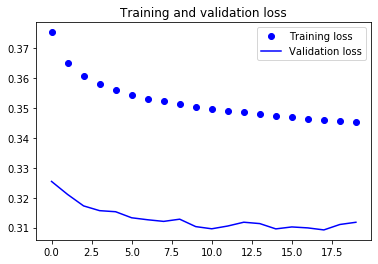

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [8]:
model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, sequences.shape[-1])))
model.add(layers.GRU(64, activation='relu',
                     dropout=0.1, 
                     recurrent_dropout=0.5))
model.add(layers.Dense(36))
model.summary()

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit(sequences, tgt,
                    batch_size=None,
                    verbose=1,
                    steps_per_epoch=100,
                    epochs=20,
                    validation_split = 0.2,
                    validation_steps = 20)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, None, 32)          6624      
_________________________________________________________________
gru_3 (GRU)                  (None, 64)                18624     
_________________________________________________________________
dense_2 (Dense)              (None, 36)                2340      
Total params: 27,588
Trainable params: 27,588
Non-trainable params: 0
_________________________________________________________________
Train on 9996 samples, validate on 2500 samples
Epoch 1/20
100/100 [==============================] - ETA: 4:33 - loss: 0.792 - ETA: 2:29 - loss: 0.781 - ETA: 1:48 - loss: 0.773 - ETA: 1:27 - loss: 0.765 - ETA: 1:14 - loss: 0.759 - ETA: 1:05 - loss: 0.752 - ETA: 59s - loss: 0.746 - ETA: 55s - loss: 0.74 - ETA: 51s - loss: 0.73 - ETA: 48s - loss: 0.72 - ETA: 45s - loss: 0.72 - ETA: 43s - loss: 0.71 -

Epoch 4/20
100/100 [==============================] - ETA: 28s - loss: 0.39 - ETA: 27s - loss: 0.39 - ETA: 27s - loss: 0.39 - ETA: 27s - loss: 0.39 - ETA: 27s - loss: 0.39 - ETA: 26s - loss: 0.39 - ETA: 26s - loss: 0.39 - ETA: 26s - loss: 0.39 - ETA: 26s - loss: 0.39 - ETA: 25s - loss: 0.39 - ETA: 25s - loss: 0.39 - ETA: 25s - loss: 0.39 - ETA: 24s - loss: 0.39 - ETA: 24s - loss: 0.39 - ETA: 24s - loss: 0.39 - ETA: 24s - loss: 0.39 - ETA: 23s - loss: 0.39 - ETA: 23s - loss: 0.39 - ETA: 23s - loss: 0.39 - ETA: 23s - loss: 0.39 - ETA: 22s - loss: 0.39 - ETA: 22s - loss: 0.39 - ETA: 22s - loss: 0.39 - ETA: 21s - loss: 0.39 - ETA: 21s - loss: 0.39 - ETA: 21s - loss: 0.39 - ETA: 21s - loss: 0.39 - ETA: 20s - loss: 0.39 - ETA: 20s - loss: 0.39 - ETA: 20s - loss: 0.39 - ETA: 19s - loss: 0.39 - ETA: 19s - loss: 0.39 - ETA: 19s - loss: 0.39 - ETA: 19s - loss: 0.39 - ETA: 18s - loss: 0.39 - ETA: 18s - loss: 0.39 - ETA: 18s - loss: 0.39 - ETA: 17s - loss: 0.39 - ETA: 17s - loss: 0.39 - ETA: 17s -

100/100 [==============================] - ETA: 28s - loss: 0.37 - ETA: 28s - loss: 0.37 - ETA: 27s - loss: 0.37 - ETA: 27s - loss: 0.37 - ETA: 27s - loss: 0.37 - ETA: 27s - loss: 0.37 - ETA: 26s - loss: 0.37 - ETA: 26s - loss: 0.37 - ETA: 26s - loss: 0.37 - ETA: 26s - loss: 0.37 - ETA: 25s - loss: 0.37 - ETA: 25s - loss: 0.38 - ETA: 25s - loss: 0.38 - ETA: 24s - loss: 0.37 - ETA: 24s - loss: 0.37 - ETA: 24s - loss: 0.37 - ETA: 24s - loss: 0.37 - ETA: 23s - loss: 0.37 - ETA: 23s - loss: 0.37 - ETA: 23s - loss: 0.37 - ETA: 22s - loss: 0.37 - ETA: 22s - loss: 0.37 - ETA: 22s - loss: 0.37 - ETA: 22s - loss: 0.37 - ETA: 21s - loss: 0.37 - ETA: 21s - loss: 0.37 - ETA: 21s - loss: 0.37 - ETA: 20s - loss: 0.37 - ETA: 20s - loss: 0.37 - ETA: 20s - loss: 0.37 - ETA: 20s - loss: 0.37 - ETA: 19s - loss: 0.37 - ETA: 19s - loss: 0.37 - ETA: 19s - loss: 0.37 - ETA: 18s - loss: 0.37 - ETA: 18s - loss: 0.37 - ETA: 18s - loss: 0.37 - ETA: 17s - loss: 0.37 - ETA: 17s - loss: 0.37 - ETA: 17s - loss: 0.37

100/100 [==============================] - ETA: 28s - loss: 0.37 - ETA: 28s - loss: 0.37 - ETA: 28s - loss: 0.37 - ETA: 27s - loss: 0.37 - ETA: 27s - loss: 0.37 - ETA: 27s - loss: 0.37 - ETA: 26s - loss: 0.37 - ETA: 26s - loss: 0.37 - ETA: 26s - loss: 0.37 - ETA: 26s - loss: 0.37 - ETA: 25s - loss: 0.37 - ETA: 25s - loss: 0.37 - ETA: 25s - loss: 0.37 - ETA: 24s - loss: 0.37 - ETA: 24s - loss: 0.37 - ETA: 24s - loss: 0.37 - ETA: 24s - loss: 0.37 - ETA: 23s - loss: 0.37 - ETA: 23s - loss: 0.37 - ETA: 23s - loss: 0.37 - ETA: 22s - loss: 0.37 - ETA: 22s - loss: 0.37 - ETA: 22s - loss: 0.37 - ETA: 22s - loss: 0.37 - ETA: 21s - loss: 0.37 - ETA: 21s - loss: 0.37 - ETA: 21s - loss: 0.37 - ETA: 20s - loss: 0.37 - ETA: 20s - loss: 0.37 - ETA: 20s - loss: 0.37 - ETA: 20s - loss: 0.37 - ETA: 19s - loss: 0.37 - ETA: 19s - loss: 0.37 - ETA: 19s - loss: 0.37 - ETA: 18s - loss: 0.37 - ETA: 18s - loss: 0.37 - ETA: 18s - loss: 0.37 - ETA: 17s - loss: 0.37 - ETA: 17s - loss: 0.37 - ETA: 17s - loss: 0.37

100/100 [==============================] - ETA: 27s - loss: 0.37 - ETA: 27s - loss: 0.37 - ETA: 27s - loss: 0.37 - ETA: 27s - loss: 0.37 - ETA: 27s - loss: 0.37 - ETA: 26s - loss: 0.37 - ETA: 26s - loss: 0.37 - ETA: 26s - loss: 0.37 - ETA: 25s - loss: 0.37 - ETA: 25s - loss: 0.37 - ETA: 25s - loss: 0.37 - ETA: 25s - loss: 0.37 - ETA: 24s - loss: 0.37 - ETA: 24s - loss: 0.37 - ETA: 24s - loss: 0.37 - ETA: 23s - loss: 0.37 - ETA: 23s - loss: 0.37 - ETA: 23s - loss: 0.37 - ETA: 23s - loss: 0.37 - ETA: 22s - loss: 0.37 - ETA: 22s - loss: 0.37 - ETA: 22s - loss: 0.37 - ETA: 21s - loss: 0.37 - ETA: 21s - loss: 0.36 - ETA: 21s - loss: 0.36 - ETA: 21s - loss: 0.36 - ETA: 20s - loss: 0.36 - ETA: 20s - loss: 0.37 - ETA: 20s - loss: 0.37 - ETA: 19s - loss: 0.37 - ETA: 19s - loss: 0.37 - ETA: 19s - loss: 0.37 - ETA: 19s - loss: 0.37 - ETA: 18s - loss: 0.37 - ETA: 18s - loss: 0.37 - ETA: 18s - loss: 0.37 - ETA: 17s - loss: 0.37 - ETA: 17s - loss: 0.37 - ETA: 17s - loss: 0.37 - ETA: 17s - loss: 0.36

100/100 [==============================] - ETA: 28s - loss: 0.36 - ETA: 28s - loss: 0.36 - ETA: 28s - loss: 0.36 - ETA: 27s - loss: 0.36 - ETA: 27s - loss: 0.36 - ETA: 27s - loss: 0.36 - ETA: 26s - loss: 0.36 - ETA: 26s - loss: 0.36 - ETA: 26s - loss: 0.36 - ETA: 26s - loss: 0.36 - ETA: 25s - loss: 0.36 - ETA: 25s - loss: 0.36 - ETA: 25s - loss: 0.36 - ETA: 24s - loss: 0.36 - ETA: 24s - loss: 0.36 - ETA: 24s - loss: 0.36 - ETA: 24s - loss: 0.36 - ETA: 23s - loss: 0.36 - ETA: 23s - loss: 0.36 - ETA: 23s - loss: 0.36 - ETA: 22s - loss: 0.36 - ETA: 22s - loss: 0.36 - ETA: 22s - loss: 0.36 - ETA: 22s - loss: 0.36 - ETA: 21s - loss: 0.36 - ETA: 21s - loss: 0.36 - ETA: 21s - loss: 0.36 - ETA: 20s - loss: 0.36 - ETA: 20s - loss: 0.36 - ETA: 20s - loss: 0.36 - ETA: 20s - loss: 0.36 - ETA: 19s - loss: 0.36 - ETA: 19s - loss: 0.36 - ETA: 19s - loss: 0.36 - ETA: 18s - loss: 0.36 - ETA: 18s - loss: 0.36 - ETA: 18s - loss: 0.36 - ETA: 17s - loss: 0.36 - ETA: 17s - loss: 0.36 - ETA: 17s - loss: 0.36

100/100 [==============================] - ETA: 28s - loss: 0.36 - ETA: 27s - loss: 0.36 - ETA: 27s - loss: 0.36 - ETA: 27s - loss: 0.36 - ETA: 27s - loss: 0.36 - ETA: 26s - loss: 0.36 - ETA: 26s - loss: 0.36 - ETA: 26s - loss: 0.36 - ETA: 25s - loss: 0.36 - ETA: 25s - loss: 0.36 - ETA: 25s - loss: 0.36 - ETA: 25s - loss: 0.36 - ETA: 24s - loss: 0.36 - ETA: 24s - loss: 0.36 - ETA: 24s - loss: 0.36 - ETA: 23s - loss: 0.36 - ETA: 23s - loss: 0.36 - ETA: 23s - loss: 0.36 - ETA: 23s - loss: 0.36 - ETA: 22s - loss: 0.36 - ETA: 22s - loss: 0.36 - ETA: 22s - loss: 0.36 - ETA: 21s - loss: 0.36 - ETA: 21s - loss: 0.36 - ETA: 21s - loss: 0.36 - ETA: 21s - loss: 0.36 - ETA: 20s - loss: 0.36 - ETA: 20s - loss: 0.36 - ETA: 20s - loss: 0.36 - ETA: 19s - loss: 0.36 - ETA: 19s - loss: 0.36 - ETA: 19s - loss: 0.36 - ETA: 19s - loss: 0.36 - ETA: 18s - loss: 0.36 - ETA: 18s - loss: 0.36 - ETA: 18s - loss: 0.36 - ETA: 17s - loss: 0.36 - ETA: 17s - loss: 0.36 - ETA: 17s - loss: 0.36 - ETA: 17s - loss: 0.36

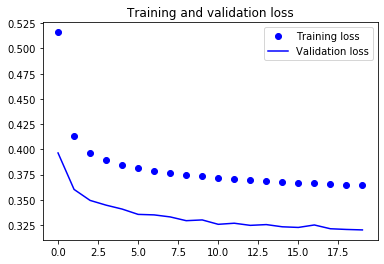

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()